# AI vs Human Art ML Project


Introduction: This notebook our submission for our Machine Learning final project. This project aims to use image classification to predict AI art or human art images.

### Step 1: Data Loading




In [16]:
import pathlib
# import all the required packages
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
import pathlib
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import random
import cv2
import os

import numpy as np

#### Loading the Training Data:
The training data and test data must be loaded differently as the train folder has the typical structure of having subfolders for the 2 classes. The test folder doesn't have any subfolders so the images are not divided by their classes.

The training split will be 70 %

In [4]:
# Loading the training data
labels = ['AI_GENERATED', 'NON_AI_GENERATED']
img_size = 224
batch_size = 32

# File path to the training data
data_dir = pathlib.Path('data/train')

# Loading the training data
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3, # Set aside 30% of the data for validation
    subset="training", # The remaining 70% is kept for training
    seed=123, # Seed helps ensure the same shuffle order
    image_size=(img_size, img_size),
    batch_size= batch_size,
)

# Load the validation data
val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation", # This keeps the 30% for validation
    seed=123, # Matches the seed from the training data
    image_size=(img_size, img_size),
    batch_size= batch_size,
)


Found 18618 files belonging to 2 classes.
Using 13033 files for training.
Found 18618 files belonging to 2 classes.
Using 5585 files for validation.


In [5]:
# Checking the class names are correct
class_names = train_data.class_names
print(f"Classes found: {class_names}")

Classes found: ['AI_GENERATED', 'NON_AI_GENERATED']


The class names were correctly loaded. The actual file structure:
[Insert Picture]
/n

Now to load the test data, adjusting for its structure. To do this I decided to create a subfolder in the test data named unknown. Doing this allows the same tf.keras.utils.image_dataset_from_directory to be used for the test data. This function looks for a subfolder so if this unknown folder is not there the function will fail and return no files found. This was a simplier fix then creating a custom function to adjust this issue.

In [22]:
# Load the test data
test_dir = 'data/test'
test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode=None, # No labels should be used for testing
    shuffle = False, # The order should be preserved for the testing data so the predictions generated during modeling could be matched to each image
    image_size=(img_size, img_size),
    batch_size=batch_size,
)

Found 43442 files.


The number of files in the test data matches the amount of data described in the original source(Kaggle), so the data has been loaded correctly

# Step 2: Visualize the data

AI_GENERATED : 7238
NON_AI_GENERATED : 5795


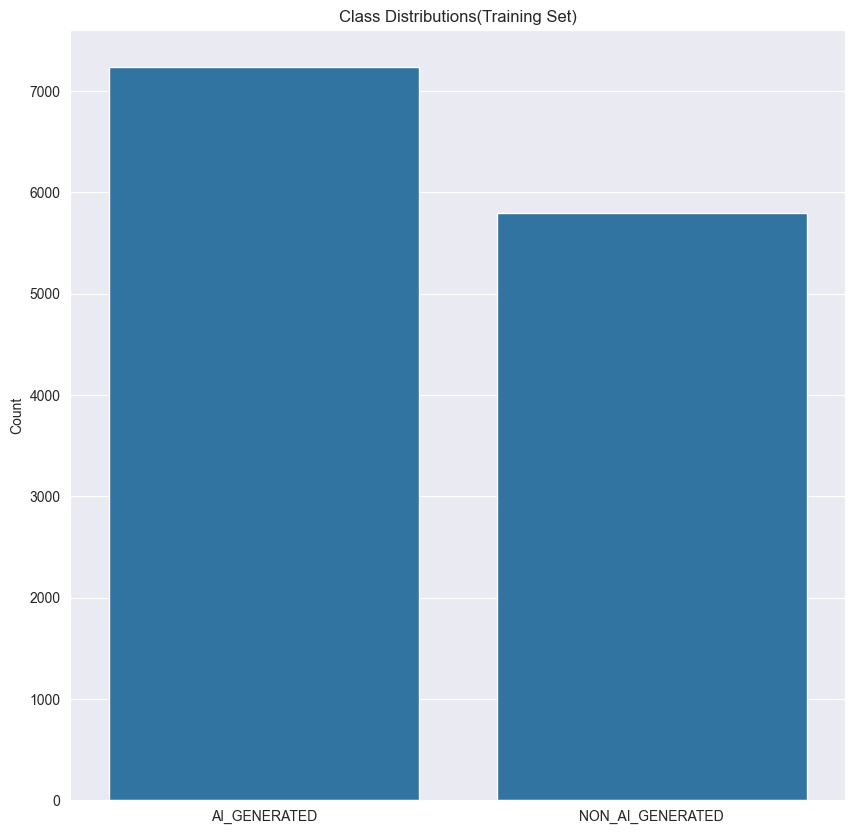

In [7]:
# Visualize the classes in the training data
y_labels = []

# Collecting the labels from the training data
for images, labels in train_data:
    y_labels.extend(labels.numpy())

# Assign the labels
class_names = train_data.class_names
l = [class_names[label] for label in y_labels]

# Print the counts for each class
for name in class_names:
    count= l.count(name)
    print(f"{name} : {count}")

# Plot the counts for the classes
plt.figure(figsize=(10, 10))
sns.countplot(x = l)
plt.title("Class Distributions(Training Set)")
plt.ylabel("Count")
plt.show()

Imbalanced data :(


In order to handle this imbalance we will implement class weights. A higher weight will be applied to the NON_AI class so there will be a higher penalty placed on errors made on the NON_AI class this way the classes will be more balanced despite the difference in the counts.


For now lets continue to make some visualizations on the data



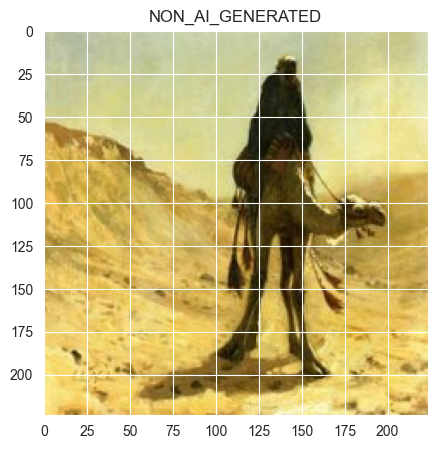

In [8]:
# Preview an image from the training data
# Get the first batch in the data
image_batch, label_batch = next(iter(train_data))
idx = 0

# Create the plot
plt.figure(figsize=(5, 5))
plt.imshow(image_batch[idx].numpy().astype("uint8"))
label_index = label_batch[idx]
plt.title(class_names[label_index])
plt.axis("on") # Show a grid
plt.show()

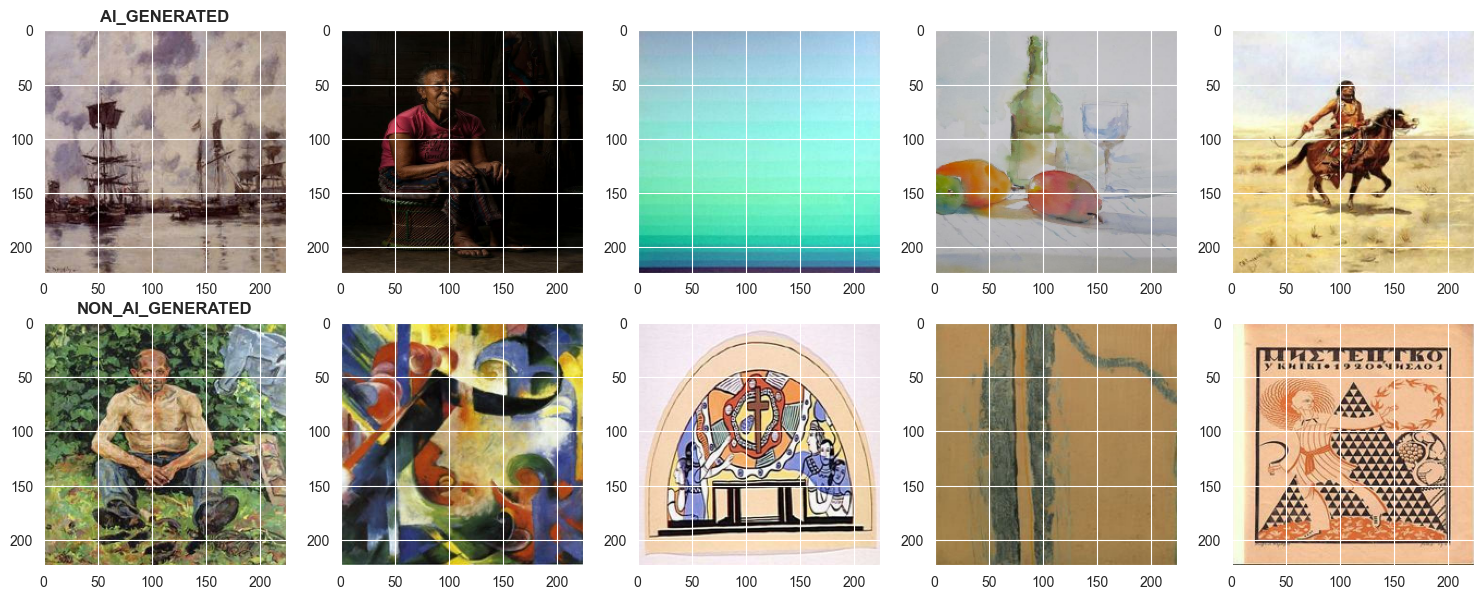

In [9]:
# Preview 5 images from each class
def preview_image(dataset, num_img = 5):
    ai =[]
    real =[]
    # Iterate through the dataset batches filling the ai and real image lists
    for images, labels in dataset:
        batch_imgs = images.numpy().astype("uint8")
        batch_labels = labels.numpy()

        # Iterate through the images in the batch check for their labels if there is AI and NON AI images
        for i in range(len(batch_labels)):
            if batch_labels[i] and  len(ai) < num_img:
                ai.append(batch_imgs[i])

            elif batch_labels[i] == 1 and len(real) < num_img:
                real.append(batch_imgs[i])
        # Once there is 5 of each class then break
        if len(ai) >= num_img and len(real) >= num_img:
            break

    # Create Plot
    fig, axes = plt.subplots(2, num_img, figsize=(15, 6))
    class_names = dataset.class_names # ['AI_GENERATED', 'NON_AI_GENERATED']

    # Row 1: AI Images
    for i in range(num_img):
        axes[0, i].imshow(ai[i])
        if i == 0:
            axes[0, i].set_title(class_names[0], fontsize=12, fontweight='bold')

    # Row 2: Real Images
    for i in range(num_img):
        axes[1, i].imshow(real[i])
        if i == 0:
            axes[1, i].set_title(class_names[1], fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

preview_image(train_data, num_img=5)

# Step 2: Data Preprocessing and Data Augmentation

First preprocessing step that must be done is adjusting the weights to adjust for the class imbalance ad discussed earlier.

In [10]:
# These are the class counts from the class distribution  found in the data exploration section
count_ai = 7238
count_non_ai = 5795
total = count_ai + count_non_ai

# Formula: Total_Samples / (2 * Class_Count)
# This formula is used give more weight to the minority class(NON_AI)
weight_0 = total / (2 * count_ai)      # AI_GENERATED
weight_1 = total / (2 * count_non_ai)  # NON_AI_GENERATED

class_weights = {0: weight_0, 1: weight_1}

print(f"Weight for Class 0 (AI): {weight_0:.2f}")
print(f"Weight for Class 1 (Non-AI): {weight_1:.2f}")

Weight for Class 0 (AI): 0.90
Weight for Class 1 (Non-AI): 1.12


Now with the weight imbalanced handled the next step is to perform data augmentation.

In [11]:
# Add data augmentation(allows the model to perform better)
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.08), # Adds rotation to the images
    layers.RandomFlip("horizontal"), # Flips the images horizontally
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1) # Shifts the images
])

# Step 3: Define the model

In [12]:
model = Sequential()

# 1. Add Data Augmentation (Only active during training)
model.add(data_augmentation)

# 2. Add Rescaling (0-255 -> 0-1) AND fix the Input Shape to 180
model.add(Rescaling(1./255, input_shape=(180, 180, 3)))

# 3. Convolutional Layers
model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

# 4. Dense Layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))

# 5. Output Layer: Adjusted for Binary Classification
#    Use 1 unit with 'sigmoid' for 2 classes
model.add(Dense(1, activation="sigmoid"))

model.summary()

C:\Users\George\PycharmProjects\AI-Art-Detection\.venv\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Step 4: Train the Model

In [17]:
early_stopping = EarlyStopping(
    monitor='val_loss',         # Watch the validation loss
    patience=5,                 # Stop if it doesn't improve for 5 epochs
    restore_best_weights=True,  # IMPORTANT: Revert to the best version, not the last version
    verbose=1
)

# 3. Train the Model
#    We pass the class_weights we calculated earlier to handle the imbalance
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,                  # Set this high (e.g., 50); EarlyStopping will stop it sooner
    callbacks=[early_stopping],
    class_weight=class_weights  # The dictionary {0: 0.90, 1: 1.12}
)

Epoch 1/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 158s 384ms/step - accuracy: 0.7019 - loss: 0.5650 - val_accuracy: 0.7465 - val_loss: 0.5024
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 158s 387ms/step - accuracy: 0.7634 - loss: 0.4859 - val_accuracy: 0.8172 - val_loss: 0.4037
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 152s 371ms/step - accuracy: 0.7850 - loss: 0.4490 - val_accuracy: 0.8209 - val_loss: 0.4065
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 157s 385ms/step - accuracy: 0.7908 - loss: 0.4275 - val_accuracy: 0.8376 - val_loss: 0.3765
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 153s 376ms/step - accuracy: 0.8023 - loss: 0.4133 - val_accuracy: 0.8315 - val_loss: 0.3864
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 160s 391ms/step - accuracy: 0.8198 - loss: 0.3960 - val_accuracy: 0.8353 - val_loss: 0.3922
Epoch 7/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 156s 383ms/step - accuracy: 0.8350 - loss: 0.3688 - val_accuracy: 0.8464 - val_loss: 0.3567
Epoch 8/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 154s 376ms/step - accuracy: 0.8356 -

# Step 5: Evaluating the Result

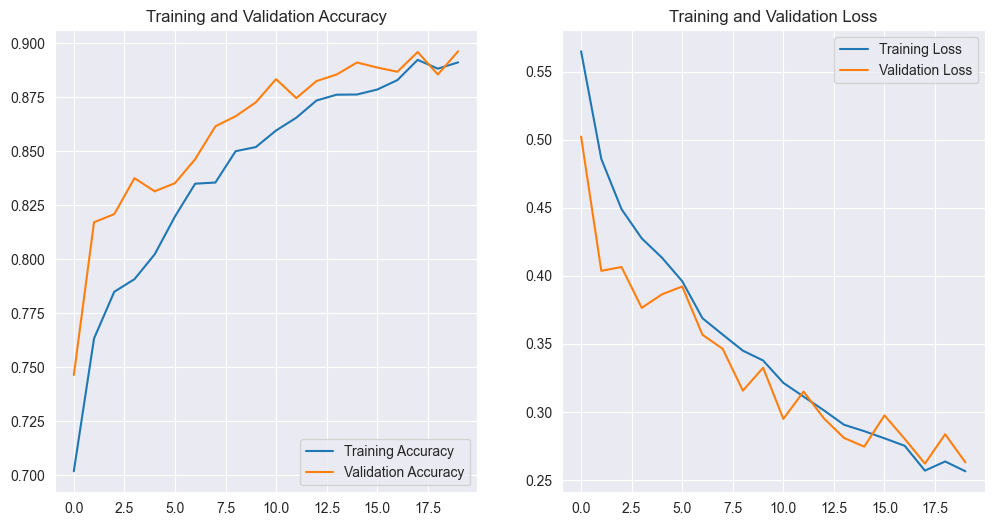

In [18]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# ========== 2. Print Final Metrics ==========
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print("\n" + "="*50)
print("FINAL TRAINING RESULTS")
print("="*50)
print(f"Training Accuracy:   {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")
print("="*50)


FINAL TRAINING RESULTS
Training Accuracy:   0.8912 (89.12%)
Validation Accuracy: 0.8963 (89.63%)
Training Loss:       0.2564
Validation Loss:     0.2629


In [20]:
# ========== 3. Evaluate on Validation Set ==========
print("\nEvaluating on validation set...")

# Use 'val_ds' instead of 'val_gen'
# You don't need 'steps' because the dataset knows its own size
val_loss, val_accuracy = model.evaluate(val_data, verbose=1)

print(f"\nConfirmed Best Validation Loss: {val_loss:.4f}")
print(f"Confirmed Best Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")


Evaluating on validation set...
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.8960 - loss: 0.2620

Confirmed Best Validation Loss: 0.2620
Confirmed Best Validation Accuracy: 0.8960 (89.60%)


# Step 6: Making Predictions

In [23]:
import numpy as np
import os

# 1. Make Predictions
print("Making predictions on test set...")
# We don't need 'steps'; TensorFlow knows when the dataset ends
predictions = model.predict(test_data, verbose=1)

# 2. Process Sigmoid Outputs (Probability -> Class)
# The model outputs a single number between 0 and 1 (Probability of Class 1 / NON_AI)
predicted_probs = predictions.flatten() # Convert shape (N, 1) -> (N,)

# Threshold: If > 0.5, it's Class 1. Else Class 0.
predicted_classes = (predicted_probs > 0.5).astype(int)

# 3. Calculate Confidence
# If prob is 0.9, confidence is 90%. If prob is 0.1, confidence is also 90% (sure it's class 0).
confidence_scores = np.where(predicted_classes == 1, predicted_probs, 1 - predicted_probs)

# 4. Get File Paths (Preserved because shuffle=False)
test_paths = test_data.file_paths
class_names = ['AI_GENERATED', 'NON_AI_GENERATED'] # 0, 1

# 5. Print Statistics
print(f"\nTotal test predictions: {len(predicted_classes)}")
ai_count = np.sum(predicted_classes == 0)
real_count = np.sum(predicted_classes == 1)

print(f"Predicted as {class_names[0]}: {ai_count} ({ai_count/len(predicted_classes)*100:.1f}%)")
print(f"Predicted as {class_names[1]}: {real_count} ({real_count/len(predicted_classes)*100:.1f}%)")
print(f"Average confidence: {np.mean(confidence_scores):.2%}")

Making predictions on test set...
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 100s 73ms/step

Total test predictions: 43442
Predicted as AI_GENERATED: 24339 (56.0%)
Predicted as NON_AI_GENERATED: 19103 (44.0%)
Average confidence: 90.57%


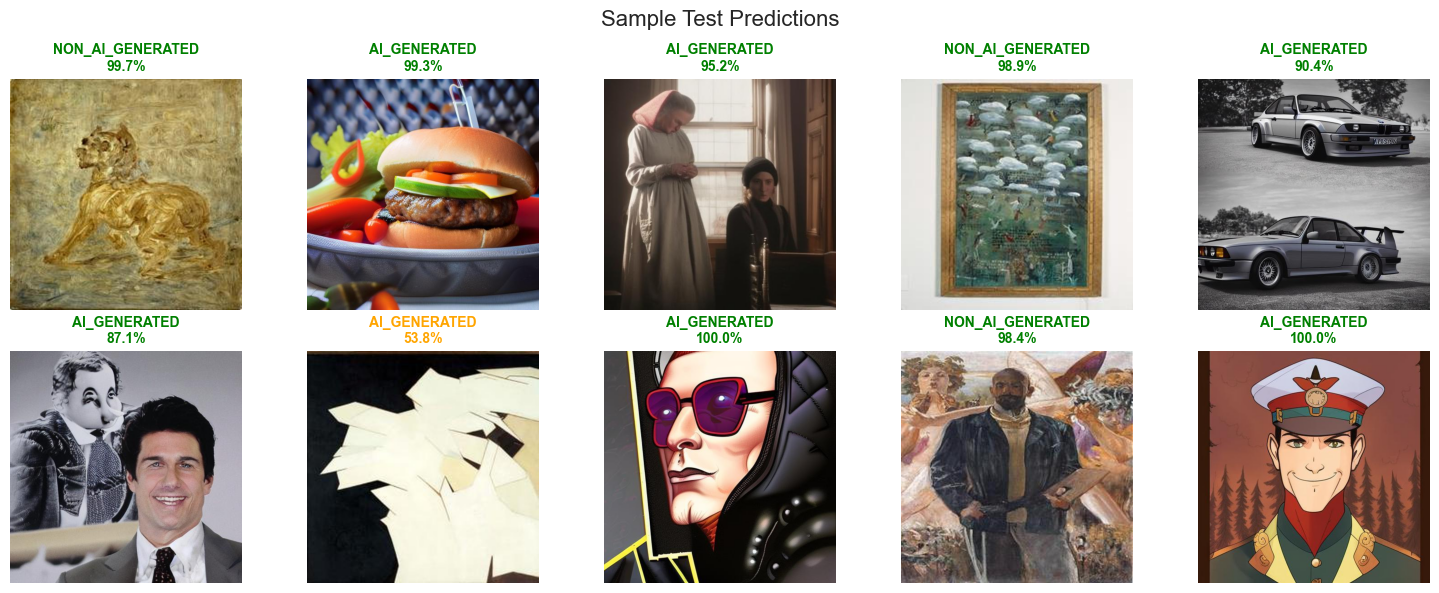

In [24]:
import matplotlib.pyplot as plt
import cv2

# Settings
num_samples = 10
indices = np.random.choice(len(test_paths), min(num_samples, len(test_paths)), replace=False)

plt.figure(figsize=(15, 6))
plt.suptitle('Sample Test Predictions', fontsize=16)

for i, idx in enumerate(indices):
    ax = plt.subplot(2, 5, i + 1)

    # Load image manually using the path (simplest way for random access)
    path = test_paths[idx]
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Fix color for matplotlib

    # Get Prediction Info
    pred_label = class_names[predicted_classes[idx]]
    conf = confidence_scores[idx]
    filename = os.path.basename(path)

    # Display
    plt.imshow(img)
    plt.axis("off")

    # Color code title: Green (High Conf), Yellow (Low Conf)
    title_color = 'green' if conf > 0.8 else 'orange'
    plt.title(f"{pred_label}\n{conf:.1%}", color=title_color, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()